In [1]:
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from scipy import sparse
import math

%matplotlib inline

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data/")

ORDERS = os.path.join(DATA_DIR, "orders.csv")
REVIEWS = os.path.join(DATA_DIR, "reviews.csv")
SIZE_MAPPINGS = os.path.join(DATA_DIR, "size_mapping.csv")
STYLE_ATTR = os.path.join(DATA_DIR, "style_attributes.csv")
USER_ATTR = os.path.join(DATA_DIR, "user_attributes.csv")

DATE_FRMT = "%Y-%m-%d"

#Read in data
orders = pd.read_csv(ORDERS)
reviews = pd.read_csv(REVIEWS)
#size_mappings = pd.read_csv(SIZE_MAPPINGS)
#style_attr = pd.read_csv(STYLE_ATTR)
user_attr = pd.read_csv(USER_ATTR)


In [3]:
def to_dates(df, cols):
    _df = df.copy()
    for col in cols:
        _df[col] = pd.to_datetime(df[col], format=DATE_FRMT)
    return _df

# Orders

 - 1231230 total records, only 1228395 are unique order_ids (~3000 duplicates)
 - 35000 unique user_ids (top has ~ 300 orders)
 - ordered_date between 2017-01-01 and 2018-03-31
 - rental begins between 2017-01-04 and 2018-07-14 (about 1.5 years of data)
 - 4000 unique styles, top 1551
 - 24167 unique skus top 556
 - no missing values
 
 # Questions
 - Why duplicate order_ids?  Are they full-row duplicates (Yes)
 - distribution of user order frequency, how many repeat interactions
 - Last date for ordered_date id 2018-03-31, last date for rental begins is 2018-07-14 (does this imply 3.5 month lag?)
 - does days_rented correlate to satisfaction / fit
 
 ## Collobartive Filtering 
 


In [4]:
orders = to_dates(orders, ['ordered_date', 'rental_begin_date'])
orders.drop_duplicates(inplace=True)
orders.describe(include='all')


,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
count,1228395,1228395,1228395,1228395,1228395,1228395,1.228395e+06
unique,1228395,35000,433,378,4000,24167,NaN
top,1b192aeb-548a-388f-a6a7-a58cb1ce751c,a44957e3-180b-3fe0-a2e6-ef83b2cc17c5,2017-10-17 00:00:00,2017-12-20 00:00:00,SAL28,KS95_ONESIZE,NaN
freq,1,307,9436,12296,1549,556,NaN
first,NaN,NaN,2017-01-01 00:00:00,2017-01-04 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-03-31 00:00:00,2018-07-14 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.242047e+01
std,NaN,NaN,NaN,NaN,NaN,NaN,2.997819e+01
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00


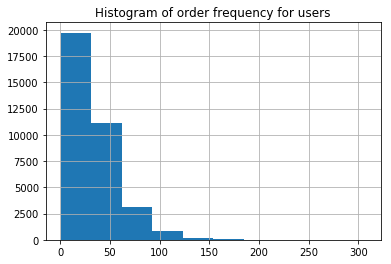

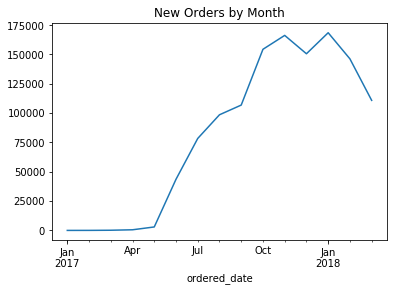

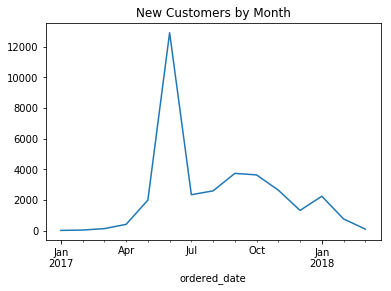

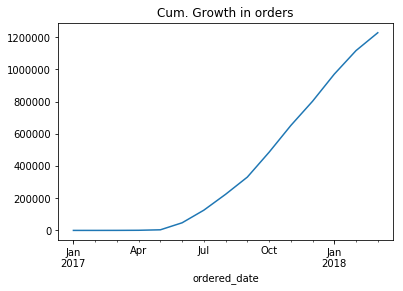

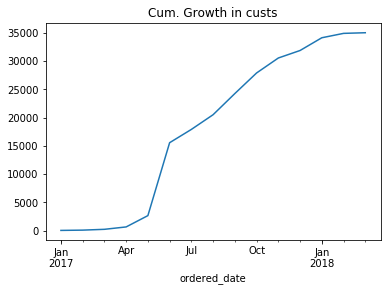

In [5]:
def make_orders_plots(df):
    _df = df.copy()
    
    plt.figure()
    ax = plt.gca()
    _df[['user_id']].apply(pd.value_counts).hist(ax=ax)
    ax.set_title("Histogram of order frequency for users")

    
    _df = _df.set_index("ordered_date").sort_index()
    _df['order_cnt'] = 1
    _df['cust_cnt'] = ~_df['user_id'].duplicated()
    _df['order_cum'] = _df['order_cnt'].cumsum()
    _df['cust_cum'] = _df['cust_cnt'].cumsum()
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Orders by Month")

    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Customers by Month")
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in orders")
    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in custs")

make_orders_plots(orders)

In [6]:
from pandas.api.types import CategoricalDtype
reviews.drop_duplicates(inplace=True)
reviews['did_you_wear_it'] = reviews['did_you_wear_it'].astype('category')

like_it_cat_type = CategoricalDtype(categories=['just_okay', 'liked_it', 'loved_it'], ordered=True)
reviews['how_did_you_like_it'] = reviews['how_did_you_like_it'].astype(like_it_cat_type)

reviews['didnt_fit'] = reviews['didnt_fit'].astype('category')
reviews['size_overall'] = reviews['size_overall'].astype('category')
reviews['size_chest'] = reviews['size_chest'].astype('category')
reviews['size_waist'] = reviews['size_waist'].astype('category')
reviews['size_waist.1'] = reviews['size_waist.1'].astype('category')
reviews['length'] = reviews['length'].astype('category')
reviews['not_flattering'] = reviews['not_flattering'].astype('category')
reviews['not_my_style'] = reviews['not_my_style'].astype('category')
reviews['other_issue'] = reviews['other_issue'].astype('category')

In [7]:
#reviews = to_dates(reviews, ['reviewed_date'])
reviews.describe(include='all')
#reviews.size_overall.value_counts()

,order_id,reviewed_date,did_you_wear_it,how_did_you_like_it,didnt_fit,size_overall,size_chest,size_waist,size_waist.1,size_hips,length,not_flattering,not_my_style,other_issue
count,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395
unique,1228395,287,2,3,2,4,4,4,4,4,4,2,2,2
top,1b192aeb-548a-388f-a6a7-a58cb1ce751c,2018-03-06,1,loved_it,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,0
freq,1,9536,832228,490571,1092882,1092882,1092882,1092882,1092882,1092882,1092882,1103353,1175706,1116430


In [11]:
def prepare_data(orders_df, reviews_df):
    
    _orders_df = orders_df.copy()
    _reviews_df = reviews_df.copy()
    _orders_df.set_index("order_id", inplace=True)
    joined = reviews_df.join(_orders_df, how='left', on="order_id")
    joined = joined[['user_id','style','didnt_fit']]
    joined['didnt_fit'] = joined['didnt_fit'].astype(int)
    joined.loc[joined['didnt_fit'] == 0, 'didnt_fit'] = 10
    return joined.groupby(['user_id','style'])['didnt_fit'].mean().unstack()
    
g = prepare_data(orders, reviews)

In [161]:
train_data = g.sample(frac=1)
test_data = g[~g.index.isin(train_data.index)]
print(train_data.shape)
print(test_data.shape)

(35000, 4000)
(0, 4000)


In [162]:
inds = np.nonzero(~np.isnan(train_data.values))
sps = sparse.coo_matrix((train_data.values[inds], inds), shape = train_data.shape)
sps2 = sparse.dok_matrix(sps)
print(sps.nnz)

1163193


In [ ]:
# counter = 0
# for i in sps2.items():
#     counter += 1
#     print(i[0][0], i[0][1], i[1])
#     if counter > 10:
#         break
        
np.mean(sps2)
sps2.mean()

In [163]:
#user_attr = pd.read_csv(USER_ATTR)
user_attr['bmi'] = (user_attr['weight_lbs'] / user_attr['height_in'].pow(2))*703
df = pd.DataFrame(g.index)
#user_attr.set_index('user_id', inplace=True)
df = df.join(user_attr,on='user_id',how='left')


In [164]:
temp = df['user_id'].to_dict()
inv_temp = {v: k for k, v in temp.items()}
test = np.ones(len(g.columns.values))
d = {'col1': g.columns.values, 'col2': test}
pd.DataFrame(d)
g

style,AAD1,AAD10,AAD14,AAD15,AAD16,AAD17,AAD18,AAD4,AAD5,AAD6,...,ZDV19,ZDV2,ZDV22,ZDV3,ZDV4,ZDV5,ZDV6,ZDV7,ZDV8,ZDV9
user_id,,,,,,,,,,,,,,,,,,,,,
0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00020785-d3b3-3ffd-9d1a-4be3539a260a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00029b5b-7637-3a73-9583-c1892d1aa776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000363e6-f2e3-339a-9c0d-6333d5ae5d55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00046ae2-a0b7-3b8a-a661-d563cef32248,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0004e7ac-6039-386e-a6c9-ae426e33af2b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005ce52-1e07-32e3-b0c7-3be120e8f41a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000966f4-c977-3a9d-8477-8825fa6084bb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00099f25-f544-3162-90f5-c3a64c05b792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
class MF():

    def __init__(self, R, K, user_attr, style_names, alpha, beta1, beta2, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (dok_sparse matrix)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        self.min_size = user_attr['standard_size'].min()
        self.size_incr = 1
        self.n_size = self.get_idx(user_attr['standard_size'].max(), 'size') + 1
        
        self.min_height = user_attr['height_in'].min()
        self.height_incr = 1
        self.n_height = self.get_idx(user_attr['height_in'].max(), 'height') + 1
        
        self.min_weight = user_attr['weight_lbs'].min()
        self.weight_incr = 3
        self.n_weight = self.get_idx(user_attr['weight_lbs'].max(), 'weight') + 1
        
        self.min_bmi = user_attr['bmi'].min()
        self.bmi_incr = 1
        self.n_bmi = self.get_idx(user_attr['bmi'].max(), 'bmi') + 1
                        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.iterations = iterations
        
        self.sizes = np.random.normal(scale=1./self.K, size=(self.n_size, self.K))
        self.heights = np.random.normal(scale=1./self.K, size=(self.n_height, self.K))
        self.weights = np.random.normal(scale=1./self.K, size=(self.n_weight, self.K))
        self.bmis = np.random.normal(scale=1./self.K, size=(self.n_bmi, self.K))
        
        self.user_data = user_attr.to_dict('records')
        self.user_id2idx = user_attr['user_id'].to_dict()
        self.user_id2idx = {v: k for k, v in self.user_id2idx.items()}
        
        self.style_names = style_names.values

    def get_idx(self, x, kind=['size, weight, height, bmi']):
        
        if np.isnan(x):
            return np.nan
        
        if kind == 'size':
            return math.floor((x - self.min_size) / self.size_incr)
        
        if kind == 'height':
            return math.floor((x - self.min_height) / self.height_incr)
        
        if kind == 'weight':
            return math.floor((x - self.min_weight) / self.weight_incr)
        
        if kind == 'bmi':
            return math.floor((x - self.min_bmi) / self.bmi_incr)
    
    def get_vec(self, x, kind):
        
        if np.isnan(x):
            return np.zeros(self.K)
        
        idx = self.get_idx(x, kind)
        
        if kind == 'size':
            return self.sizes[idx,:]
        
        if kind == 'height':
            return self.heights[idx,:]
        
        if kind == 'weight':
            return self.weights[idx,:]
        
        if kind == 'bmi':
            return self.bmis[idx,:]
    
    def set_vec(self, x, kind, values):
        
        if np.isnan(x):
            return
        
        idx = self.get_idx(x, kind)
        
        if kind == 'size':
            self.sizes[idx,:] = values
        
        if kind == 'height':
            self.heights[idx,:] = values
        
        if kind == 'weight':
            self.weights[idx,:] = values
        
        if kind == 'bmi':
            self.bmis[idx,:] = values
        
        return
    
                          
    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R)

        # Create a list of training samples
        self.samples = [
            (i[0][0], i[0][1], i[1])
            for i in self.R.items()
        ]
                              

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 1 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

            self.alpha = .95*self.alpha
            
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        #predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            user_dict = self.user_data[x]
            size_vec = self.get_vec(user_dict['standard_size'], 'size')
            height_vec = self.get_vec(user_dict['height_in'], 'height')
            weight_vec = self.get_vec(user_dict['weight_lbs'], 'weight')
            bmi_vec = self.get_vec(user_dict['bmi'], 'bmi')
            user_vec = (size_vec + height_vec + weight_vec + bmi_vec)
            error += pow(self.R[x, y] - self.get_rating(x,y,user_vec), 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            user_dict = self.user_data[i]
            size_vec = self.get_vec(user_dict['standard_size'], 'size')
            height_vec = self.get_vec(user_dict['height_in'], 'height')
            weight_vec = self.get_vec(user_dict['weight_lbs'], 'weight')
            bmi_vec = self.get_vec(user_dict['bmi'], 'bmi')
            user_vec = (size_vec + height_vec + weight_vec + bmi_vec)

            
            # Computer prediction and error
            prediction = self.get_rating(i, j, user_vec)
            e = (r - prediction)
            assert (not np.isnan(e)), 'broke'
        
            self.b_u[i] += self.alpha * (e - self.beta1 * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta1 * self.b_i[j])

            # Update user and item latent feature matrices
            self.Q[j, :] += self.alpha * (e * (self.P[i, :]+user_vec) - self.beta2 * self.Q[j,:])
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta2 * self.P[i,:])
            
         
            # update user features
            size_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * size_vec)
            height_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * height_vec)
            weight_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * weight_vec)
            bmi_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * bmi_vec)
            
            self.set_vec(user_dict['standard_size'], 'size', size_vec)
            self.set_vec(user_dict['height_in'], 'height', height_vec)
            self.set_vec(user_dict['weight_lbs'], 'weight', weight_vec)
            self.set_vec(user_dict['bmi'], 'bmi', bmi_vec)

    def get_rating(self, i, j, user_vec):
        """
        Get the predicted rating of user i and item j
        """           
        prediction = self.b + self.b_u[i] + self.b_i[j] + (self.P[i, :] + user_vec).dot(self.Q[j, :].T)
        return prediction
    
    def predict_for_user(self, user_id):
        """
        Get items sorted by predicted fit for a user in training set.  User bias and 
        """
        i = self.user_id2idx.get(user_id, None)
        if(not i):
            raise ValueError('User Id not found in data')
        else:
            user_dict = self.user_data[i]
            size_vec = self.get_vec(user_dict['standard_size'], 'size')
            height_vec = self.get_vec(user_dict['height_in'], 'height')
            weight_vec = self.get_vec(user_dict['weight_lbs'], 'weight')
            bmi_vec = self.get_vec(user_dict['bmi'], 'bmi')
            user_vec = (size_vec + height_vec + weight_vec + bmi_vec)
        
            predictions = self.b + self.b_u[i] + self.b_i + np.matmul(self.Q, (self.P[i, :] + user_vec).T)
            d = {'Score': predictions, 'Style': self.style_names}
            return pd.DataFrame(d).sort_values('Score')
            
        

#     def full_matrix(self):
#         """
#         Computer the full matrix using the resultant biases, P and Q
#         """
#         return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [200]:
test = MF(sps2, 100, df, g.columns, .001, .01, .01, 30)

In [201]:
test.train()

Iteration: 1 ; error = 3225.1494
Iteration: 2 ; error = 3133.0229
Iteration: 3 ; error = 3065.6920
Iteration: 4 ; error = 3007.2725
Iteration: 5 ; error = 2963.4586
Iteration: 6 ; error = 2921.9242
Iteration: 7 ; error = 2886.4666
Iteration: 8 ; error = 2856.7521
Iteration: 9 ; error = 2827.8867
Iteration: 10 ; error = 2804.9660
Iteration: 11 ; error = 2785.1786
Iteration: 12 ; error = 2768.0566
Iteration: 13 ; error = 2751.6680
Iteration: 14 ; error = 2738.8987
Iteration: 15 ; error = 2726.3359
Iteration: 16 ; error = 2715.4515
Iteration: 17 ; error = 2705.9354
Iteration: 18 ; error = 2696.0586
Iteration: 19 ; error = 2689.7301
Iteration: 20 ; error = 2682.3557
Iteration: 21 ; error = 2674.0173
Iteration: 22 ; error = 2666.8053
Iteration: 23 ; error = 2660.6852
Iteration: 24 ; error = 2655.2763
Iteration: 25 ; error = 2650.3886
Iteration: 26 ; error = 2645.2996
Iteration: 27 ; error = 2640.4690
Iteration: 28 ; error = 2637.0361
Iteration: 29 ; error = 2633.0456
Iteration: 30 ; error =

[(0, 3225.1494160848456),
 (1, 3133.022931128149),
 (2, 3065.6920010474196),
 (3, 3007.272519192972),
 (4, 2963.4586351823027),
 (5, 2921.9241856759945),
 (6, 2886.466632745564),
 (7, 2856.7520899239926),
 (8, 2827.8866703668373),
 (9, 2804.9659893540265),
 (10, 2785.1785975880407),
 (11, 2768.056629714864),
 (12, 2751.6679787031385),
 (13, 2738.8987095891216),
 (14, 2726.3359355971656),
 (15, 2715.4514989349586),
 (16, 2705.935448186103),
 (17, 2696.058636802067),
 (18, 2689.7301444164086),
 (19, 2682.355655920294),
 (20, 2674.0172502126034),
 (21, 2666.805254717988),
 (22, 2660.685206500475),
 (23, 2655.276252349149),
 (24, 2650.3885833864592),
 (25, 2645.299579153077),
 (26, 2640.468996900478),
 (27, 2637.03613327672),
 (28, 2633.045597823273),
 (29, 2628.4123748787038),
 (30, 2624.9268194011106),
 (31, 2622.1808667496593),
 (32, 2618.7630655133826),
 (33, 2615.9269477108955),
 (34, 2613.239429024137),
 (35, 2610.9772052691633),
 (36, 2608.619033446602),
 (37, 2607.286209131687),
 (

In [202]:
what = test.predict_for_user("000966f4-c977-3a9d-8477-8825fa6084bb")
what[what['Style'] == 'TH71']#880

,Score,Style
3517,7.370608,TH71


In [203]:
import pickle
filehandler = open("MF.obj","wb")
pickle.dump(test,filehandler)
filehandler.close()

file = open("MF.obj",'rb')
object_file = pickle.load(file)
file.close()

print(object_file.predict_for_user("000966f4-c977-3a9d-8477-8825fa6084bb"))

          Score  Style
3917   3.906105  WVG18
600    4.825705   CEL8
1830   4.838395   KP55
2604   4.869741   OS36
11     5.044118  ABR11
2415   5.435095  NLS15
2316   5.446967   MRR9
2627   5.521895  PK141
1374   5.569621   FP88
2446   5.684567   NLS5
2393   5.721950   NK39
1831   5.723746   KP57
1416   5.746869   GOJ6
225    5.767555   AX58
3202   5.818813  SLN22
2031   5.923622   LKL6
3359   5.926568  SW399
3214   5.932215  SLR19
752    5.985428  CVN77
166    6.005394   AQ25
1125   6.013031  EFA21
1920   6.048425   KS70
640    6.059610    CP3
601    6.068187   CEL9
2545   6.074815   NR53
2323   6.093930  MRW16
720    6.108166  CVN20
19     6.123770  ADE15
719    6.169246  CVN19
198    6.187415   AX28
...         ...    ...
1232  10.300170    EM7
2747  10.303848   PR62
2903  10.306691  RT120
3553  10.306747  TLR14
3522  10.308260   TH78
710   10.322140   CUP9
3849  10.322298   VIN4
2871  10.323043   RM78
1238  10.330387   EMS7
3846  10.333279  VIN37
3759  10.336462  TYB37
1583  10.33

In [209]:
orders_df = orders[orders['user_id'] == "000966f4-c977-3a9d-8477-8825fa6084bb"]
temp_df = reviews.set_index('order_id')
orders_df.join(temp_df, how="left")
#reviews[reviews.order_id.isin(order_ids)]
#orders.loc['order_id' == "9f965f2a-b0e3-3d26-87b7-127d9d4a2e50"]
#orders[orders['user_id'] == "0001b9a8-0a05-3677-9e1d-7fc05a9a9b67"]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented,reviewed_date,did_you_wear_it,how_did_you_like_it,didnt_fit,size_overall,size_chest,size_waist,size_waist.1,size_hips,length,not_flattering,not_my_style,other_issue
192388,20185341-5d3b-38a1-b082-6f249392d410,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,DVF99,DVF99_M,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278841,eebbcefb-412c-3bf0-8fca-50b6d7240a23,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,TH71,TH71_8,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387385,171a4c9b-6e77-3153-8949-e9afc4766552,000966f4-c977-3a9d-8477-8825fa6084bb,2017-12-05,2017-12-07,JWG2,JWG2_S,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
542576,45c8ad8a-8464-39cb-b41e-6c8d7ee4c35c,000966f4-c977-3a9d-8477-8825fa6084bb,2018-02-07,2018-02-13,KPL26,KPL26_MR,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549090,ddf56429-3df9-39b2-88ce-8576b9f37ca5,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,ER13,ER13_M,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563807,28f74027-a1a3-309a-a00b-1a49b4f47ffe,000966f4-c977-3a9d-8477-8825fa6084bb,2018-02-07,2018-02-13,CVN51,CVN51_L,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615533,77a8fbc7-fda4-3b3f-8732-19ea9c3f0490,000966f4-c977-3a9d-8477-8825fa6084bb,2018-02-07,2018-02-13,DRW2,DRW2_L,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653059,4810fbd6-c784-38f6-bd8c-a76da12cfac9,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,MRR5,MRR5_M,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
695615,9cedfe51-a364-308a-a00b-50b2722fcc3a,000966f4-c977-3a9d-8477-8825fa6084bb,2017-12-21,2017-12-27,CAS62,CAS62_M,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
731063,87332e07-1a3a-36b7-b6c9-9057b3cc9398,000966f4-c977-3a9d-8477-8825fa6084bb,2017-12-05,2017-12-07,RL4,RL4_M,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
orders.sort_values('user_id')

,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
97471,36673766-3005-3700-af31-097ca5a66822,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,ASR10,ASR10_M,9
853625,a1e67167-089f-3855-852d-0fe5e1c956f4,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2018-02-08,2018-02-12,DRW13,DRW13_M,7
253129,f4d174b7-f87a-35a1-98a6-688d2423e4ee,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,TNT24,TNT24_8,9
1151198,7e87505b-fd7a-3b65-b8cd-e5bb9af660ba,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,PK213,PK213_M,7
1211566,c152f63c-55e4-3e56-bee7-a45692ea6ccb,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,SHL2,SHL2_M,35
1160524,bf9796cc-3ae1-36a5-87c0-89e17a3cfdc5,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,CUP18,CUP18_M,35
1201341,f5f88fdd-6c56-3b34-817f-d81c9830be1b,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,CED42,CED42_44,19
648411,fe599875-0a1d-3825-a1b6-3aebdd2210a9,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,BSH10,BSH10_2,9
351339,085e7f72-191e-39e0-8d16-ba85f7f43595,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,JWG28,JWG28_10,9
891703,fcbdc570-c061-3dd6-946d-b7f71af91919,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2018-01-23,2018-01-29,DL104,DL104_L,9


In [ ]:
user_attr['bmi'] = (user_attr['weight_lbs'] / user_attr['height_in'].pow(2))*703

In [ ]:
user_attr.to_dict('records')[0]

In [ ]:
df = pd.DataFrame(g.index)
user_attr.set_index('user_id', inplace=True)
df = df.join(user_attr,on='user_id',how='left')

In [ ]:
(60 - df.height_in.min()) / 2